In [0]:
# Students:
# Carlos Eduardo Fernandes
# Yakov Nae

# Tarefa 03 - Transfer Learning
Nesta tarefa você irá carregar a SqueezeNet com pesos treinados no ImageNet e fará a transferênicia de aprendizado para um problema de classificação de raças de cachorro. 

------------
## IMPORTANTE
##### Verifique os pontos abaixo antes de começar a tarefa:
- Faça download do dataset (arquivo `INF0618_Tarefa03_dogDataset.zip`) em `https://goo.gl/r44kAQ` e descomprima o .zip no mesmo diretório deste notebook;
- Verifique se, após descomprimir .zip, há uma pasta `INF0618_Tarefa03_dogDataset` com as subpastas `train`, `test`, `val`;
- Faça o download do modelo da squeezeNet (arquivo `squeezenet_weights_tf_dim_ordering_tf_kernels.h5` disponível no Moodle). Você também pode copiar o modelo dos arquivos da Aula 04 (apenas verifique o nome do arquivo).
- Não há necessidade de alterar os códigos das sessões `Imports`, `Definição da SqueezeNet` e `Dataset`.
-----------


As tarefas são:

**1) Definição do modelo [0.25 pts]**
- Instancie o modelo base da SqueezeNet;
- Escolha qual camada da rede que você utilizará como ponto de partida (..., fire8, fire9, drop9);
- Escolha quais camadas terão os pesos atualizados e quais serão congeladas;
- Adicione as camadas adicionais no topo da rede. Vocês estão livres em relação à quantidade e tipo de camadas após a SqueezeNet.

**2) Treinamento [0.25 pts]**
- Compile o seu modelo, definindo qual a loss e otimizador que serão utilizados;
- Defina também número de batches e número de épocas;
- Treine para obter a maior acurácia que você conseguirem;

**3) Teste [0.25 pts]**
- Avalie o conjunto de teste e reporte a loss e a acurácia normalizada;

**4) Conclusões [0.25 pts]**
- Escreva um parágrafo resumindo o que você fez, as dificuldades que encontrou, o que deu certo/errado e as suas conclusões desta atividade.

------

## Imports

In [1]:
import os
import numpy as np
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.models import Model
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

# To run in https://colab.research.google.com
#from google.colab import drive
#drive.mount('/content/drive')
#datasetDir = '/content/drive/My Drive/Colab_Notebooks/INF0618_Ex03/data'
#datasetDir = '/content/drive/My Drive/INF0618_Ex03/data'


Using TensorFlow backend.


## Definição do modelo base da SqueezeNet
As funções abaixo criam o modelo da SqueezeNet e carregam os seus pesos treinados no ImageNet.

In [0]:
# Fire Module Definition
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

#SqueezeNet model definition
def SqueezeNet(input_shape):
    img_input = Input(shape=input_shape) #placeholder
    
    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

# Dataset
O dataset é composto por 83 classes (raças de cachorro) com 100 imagens de treinamento por classe. No conjunto de validação, há 73 imagens por classe. As imagens estão nomeadas no formato `xx_yyyy.jpg`, onde `xx` denota a classe (de 00 até 82) e `yyyy` é apenas um identificador da imagem.

** IMPORTANTE NÃO ALTERAR O NOME/LOCAL DAS IMAGENS** 

In [3]:
datasetDir  = "./INF0618_Tarefa03_dogDataset"
nbClasses = 83

def getDatasetSize(split='train'):
    if split not in ["train", "val", "test"]:
        raise ValueError(split + " not recognized. Did you mean 'train', 'val' or 'test'?")
    splitDir = os.path.join(datasetDir, split)
    
    #Get all file names for that split
    fileNames = [img for img in os.listdir(splitDir) if img[-3:] in ['jpg', 'png', 'jpeg']]
    return len(fileNames)

#Read our dataset in batches
def loadDatasetInBatches(split="train", batch_size=32):
    if split not in ["train", "val", "test"]:
        raise ValueError(split + " not recognized. Did you mean 'train', 'val' or 'test'?")
    splitDir = os.path.join(datasetDir, split)
    
    #Get all file names for that split
    fileNames = [img for img in os.listdir(splitDir) if img[-3:] in ['jpg', 'png', 'jpeg']]

    while True:
        shuffledFileNames = sample(fileNames, len(fileNames)) #shuffle images in each epoch
        imagePaths = [os.path.join(splitDir,img) for img in shuffledFileNames] #get image paths
        
        batch, labelList = [], []
        nInBatch = 0
        
        #loop of one epoch
        for idx in list(range(len(imagePaths))):
                        img = img_to_array(load_img(imagePaths[idx], target_size=(227, 227)))
                        img = img.astype('float32')
                        img /= 255.0
                    
                        label = np_utils.to_categorical(getLabelFromImgName(shuffledFileNames[idx], split), nbClasses)
                        
                        ######### If you want to run with Data Augmentation, just uncomment here
                        ##### you can add more transformations (see https://keras.io/preprocessing/image/)
                        ### We apply a random transformation and add this image (instead of the original)
                        ### to the batch...
                        
                        #dataAugmentator = ImageDataGenerator(horizontal_flip = True)
                        #img = dataAugmentator.random_transform(img)
                        
                        
                        batch.append(img)
                        labelList.append(label)
                        nInBatch += 1
                        
                        #if we already have one batch, yields it
                        if nInBatch >= batch_size:
                            yield np.array(batch), np.array(labelList)
                            batch, labelList = [], []
                            nInBatch = 0

        #yield the remaining of the batch
        if nInBatch > 0:
            yield np.array(batch), np.array(labelList)


def getLabelFromImgName(imgName, split):
    return int(imgName.split("_")[0])
        
    
#plot the images from imgList
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
               
def plotImage(img):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img*255.0), interpolation='nearest')
    plt.show()
    
trainSetSize = getDatasetSize("train")
valSetSize = getDatasetSize("val")
testSetSize = getDatasetSize("test")

print("# images in Train set: ", trainSetSize)
print("# images in Val set: ", valSetSize)
print("# images in Test set: ", testSetSize)

# images in Train set:  7303
# images in Val set:  5739
# images in Test set:  5420


(5, 227, 227, 3) (5, 83)


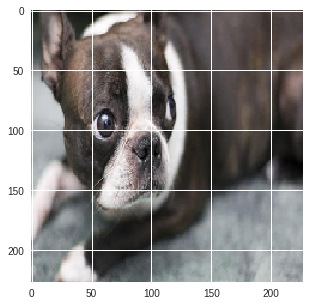

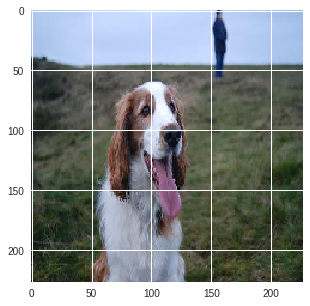

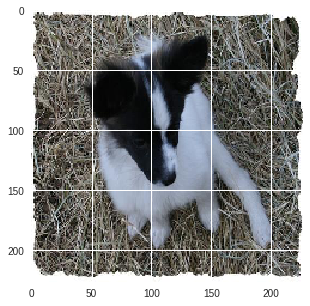

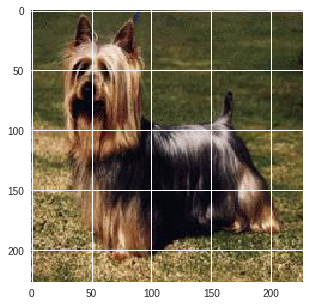

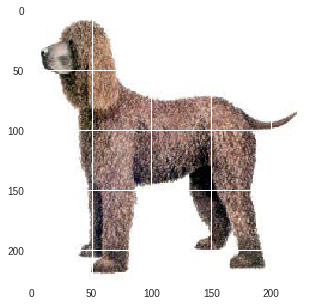

In [13]:
for batch, labels in loadDatasetInBatches(split='train', batch_size=5):
    print(batch.shape, labels.shape)
    plotImages(batch)
    break

### Como o load do dados é feito...  
O método que iremos utilizar para ler os dados é o `loadDatasetInBatches(split='train', batch_size=32)`. Ele é um generator (semelhante ao método que fazia a aumentação de dados na Aula 03), ou seja, ele gera um fluxo de batches e labels a partir do nosso dataset.

**Argumentos**:
- (string) **split**: pode ser `'train'`, `'val'` ou `'test'`. Se refere a qual conjunto de dados que iremos ler (treino, validação ou teste);
- (int) **batch_size**: quantas imagens por batch;

**Retorno**: 
- **batch**: retorna um array do numpy com as imagens carregadas e pre-processadas. **batch** tem dimensões (batch_size, 227, 227, 3), pois as imagens tem tamanho 227x227 e tem 3 canais (RGB);
- **labels**: retorna um array do numpy com as labels já transformadas em one_hot_encode (array de 83 dimensões, com 1 na posição do índice da classe e 0 nas outras posições). **batch** tem dimensões (batch_size, 83);
    
Utilizando o argumento `split`, o método lê os nomes das imagens do diretório correto e as embaralha (para garantir que a cada época os batches sejam diferentes). Para cada época (um loop do `for` interno), o método irá carregar uma imagem por vez e irá gerar a sua label (obtendo a classe pelo próprio nome da imagem). Esta imagem/label será colocada em listas **batch/labelList**.

Quando estas listas estiverem com **batch_size** elementos, teremos gerado um batch. O método dá um yield nessas duas e recomeça a construção de um novo batch. Quando o `for` terminar, iremos ter completado uma época. O `while True` apenas garante uma nova época seja iniciada. Quem controlará o fim do `while` vai ser o método que fará o fit, portanto não precisamos nos preocupar com isso.  

-----------
-----------
-----------
** -----> A tarefa começa aqui !!! Vocês não precisam modificar nada dos códigos acima!** 

# Definição do modelo [0.25 pts]

- Instancie o modelo base da SqueezeNet;
- Escolha qual camada da rede que você utilizará como ponto de partida (..., fire8, fire9, drop9);
- Escolha quais camadas terão os pesos atualizados e quais serão congeladas;
- Adicione as camadas adicionais no topo da rede. Vocês estão livres em relação à quantidade e tipo de camadas após a SqueezeNet.
    - Lembrem-se que ao final da rede, precisamos de camadas de classificação:
        - Conv2D + GlobalAveragePooling + SoftMax (aula 05)
        - Flatten + Dense + SoftMax (aulas anteriores)
    - Se acharem necessário, podem também adicionar outras camadas (Dropout, Conv2D, módulos Fire);
    
    
**Não se esqueçam de:**
- Definir novas camadas da mesma forma que fizemos na Aula 05 (utilizando o x = ...(x))
- Ao final da célula, definir o modelo novo com o input da squeeze base e o output da última camada adicionada

In [6]:
# Definir o modelo base da squeezeNet 
squeezeNetModel = SqueezeNet((227,227,3))

print([layer.name for layer in squeezeNetModel.layers])
print("\n\nFreeze layers up until ", squeezeNetModel.layers[-27].name)

['input_1', 'conv1', 'relu_conv1', 'pool1', 'fire2/squeeze1x1', 'fire2/relu_squeeze1x1', 'fire2/expand1x1', 'fire2/expand3x3', 'fire2/relu_expand1x1', 'fire2/relu_expand3x3', 'fire2/concat', 'fire3/squeeze1x1', 'fire3/relu_squeeze1x1', 'fire3/expand1x1', 'fire3/expand3x3', 'fire3/relu_expand1x1', 'fire3/relu_expand3x3', 'fire3/concat', 'pool3', 'fire4/squeeze1x1', 'fire4/relu_squeeze1x1', 'fire4/expand1x1', 'fire4/expand3x3', 'fire4/relu_expand1x1', 'fire4/relu_expand3x3', 'fire4/concat', 'fire5/squeeze1x1', 'fire5/relu_squeeze1x1', 'fire5/expand1x1', 'fire5/expand3x3', 'fire5/relu_expand1x1', 'fire5/relu_expand3x3', 'fire5/concat', 'pool5', 'fire6/squeeze1x1', 'fire6/relu_squeeze1x1', 'fire6/expand1x1', 'fire6/expand3x3', 'fire6/relu_expand1x1', 'fire6/relu_expand3x3', 'fire6/concat', 'fire7/squeeze1x1', 'fire7/relu_squeeze1x1', 'fire7/expand1x1', 'fire7/expand3x3', 'fire7/relu_expand1x1', 'fire7/relu_expand3x3', 'fire7/concat', 'fire8/squeeze1x1', 'fire8/relu_squeeze1x1', 'fire8/expa

In [0]:
import pandas as pd
    
def myPlot(history, epochs):
    fig1, ax1 = plt.subplots()
    plt.plot(range(epochs),history.history['val_loss'],'go-', label='validation loss')
    plt.plot(range(epochs),history.history['loss'],'go-', color = 'red', label='train loss')
    plt.legend()

    fig2, ax2 = plt.subplots() # two axes on figure
    plt.plot(range(epochs),history.history['val_acc'], '-g+',  label='acc validation')
    plt.plot(range(epochs),history.history['acc'], '-g+',   color = 'red', label='acc trainning')
    plt.legend()

In [0]:
from keras.layers.core import Flatten, Dense
from keras import regularizers

def getModel(reg=0.01):

    seed(42)
    np.random.seed(42)
  
    # Definir o modelo base da squeezeNet 
    squeezeNetModel = SqueezeNet((227,227,3))

    # Congelar (ou não) camadas
    for layer in squeezeNetModel.layers[:-27]:
        layer.trainable = False

    # Escolher a camada que será o ponto de partida 
    x = squeezeNetModel.get_layer(name='drop9').output
    # Adicionar novas camadas
    x = Dropout(0.25)(x)
    x = Convolution2D(nbClasses, (1,1), padding='valid', name='conv10_new')(x)
    x = BatchNormalization()(x)
    x = Activation('softmax', name='softmax_conv10_new')(x)
    x = GlobalAveragePooling2D()(x)


    x = Dropout(0.25)(x)
    x = BatchNormalization()(x)
    x = Dense(nbClasses, activation='softmax',kernel_regularizer=regularizers.l2(reg),
                   activity_regularizer=regularizers.l1(reg))(x)
  
    model = Model(squeezeNetModel.inputs, x, name='squeezenet_new')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # CARLOS
    
    return model
  
  
def trainModel(reg, epochs, batch_size):
  
    print("# trainModel - reg: ", reg)
    print("# trainModel - epochs: ", epochs)
    print("# trainModel - batch_size: ", batch_size)
  
    if (reg == -1):
        model = getModel()
    else:
        model = getModel(reg)

    #Compile o modelo#Compile 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    #Criação dos generators
    trainGenerator = loadDatasetInBatches(split='train', batch_size = batch_size)
    valGenerator = loadDatasetInBatches(split='val', batch_size = batch_size)

    #Fit nos dados
    history = model.fit_generator(trainGenerator, 
                    steps_per_epoch= int(trainSetSize / batch_size), 
                    epochs = epochs,
                    validation_data = valGenerator,  
                    validation_steps = int(valSetSize / batch_size))
    
    myPlot(history, epochs)
    
    return (history, model)

    


# Treinamento [0.25 pts]

- Compile o seu modelo, definindo qual a loss e otimizador que serão utilizados;
- Defina também número de batches e número de épocas;
- Treine para obter a maior acurácia que você conseguirem;


No treinamento iremos utilizar o `fit_generator` (mesmo utilizado no Aula03 com Data Augmentation). Ele recebe um generator (que será fornecido pelo `loadDatasetInBatches`). Como o generator retorna um fluxo de batches/labels, o `fit_generator` não tem informação sobre o tamanho dataset. Por isso, precisamos informar o número de épocas (parâmetro `epochs`) e também quantos batches compõe uma época (parâmetro `steps_per_epoch`). Ao total, teremos 2 generators, um para o conjunto de treino e outro para o conjunto de teste.

Para mais informações sobre o fit_generator e seus parâmetros, [acesse a documentação do Keras](https://keras.io/models/sequential/#fit_generator).

Cell below will run search for the best batch-size in interval: **32, 64, 96, 128, 160, 192, 224, 256, 288,320**
It runned in google collab and results were saved in Google Drive, then script **ViewResults.ipynb** plots graphs of accuracy and loss for each batch-size

In [18]:
#Definir tamanho do batch e número de épocas
import time
import timeit
import pickle

#Fit nos dados
h=[]
t=[]
b=[]
tst=[]
N=10
epochs = 20 #CARLOS

# Find the best batch_size in sequence: 32, 64, 96, 128, 160, 192, 224, 256, 288, 320
for i in range(1,N):
    
    batch_size=32*i
    print('sample ' , i , 'of' , N , '  batch=' , batch_size)
    start = timeit.timeit()
    
    model = getModel(batch_size)
    
    #Criação dos generators
    trainGenerator = loadDatasetInBatches(split='train', batch_size = batch_size)
    valGenerator = loadDatasetInBatches(split='val', batch_size = batch_size)
    seed(42)
    i_train_steps = int(trainSetSize / batch_size)
    i_valid_steps = int(valSetSize / batch_size)
    i_test_steps  = int(testSetSize/batch_size)
#    i_train_steps = 5
#    i_valid_steps = 5
#    i_test_steps  = 5
    history = model.fit_generator(trainGenerator, 
                            steps_per_epoch = i_train_steps, 
                            epochs = epochs,
                            validation_data = valGenerator,  
                            validation_steps = i_valid_steps)

    ######### 
    ### Code below saves the results of model for each batch_size in a file in google drive, then another
    ### notebook (ViewResults.ipynb) is responsible to plot graphs of them.
    ### Although, we run and pass the test results to ViewResults, these data is not used in our analysis. But once,
    ### it takes a lot of time and we noticed it only after the full execution, we decided keep the code in order
    ### to use the generated graphs and warn that it is wrong and we didn't use that.
    #########

    #h.append(history)
    #t.append(timeit.timeit()-start)
    #b.append(batch_size)

    #Teste
    #testGenerator = loadDatasetInBatches(split='test', batch_size=batch_size)
    #metrics = model.evaluate_generator(testGenerator, 
    #                                   steps=i_test_steps, 
    #                                   verbose=1)
    #tst.append({'loss' : metrics[0], 'acc' : metrics[1]})
    
    #SAVE RESULTS FOR CURRENT BUFFER SIZE:
    #with open(datasetDir +'/res/00_res_Carlos_CPU.pkl', 'wb') as f:
    #     pickle.dump([h, t, b, tst], f)
    #    time.sleep(120)


sample  1 of 10   batch= 32
Epoch 1/20
228/228 [==============================] - 104s 454ms/step - loss: 5.0110 - acc: 0.0350 - val_loss: 4.6315 - val_acc: 0.0580
Epoch 2/20
228/228 [==============================] - 101s 443ms/step - loss: 4.4422 - acc: 0.0774 - val_loss: 4.2783 - val_acc: 0.0855
Epoch 3/20
228/228 [==============================] - 102s 448ms/step - loss: 4.1456 - acc: 0.1073 - val_loss: 4.0338 - val_acc: 0.1309
Epoch 4/20
228/228 [==============================] - 100s 439ms/step - loss: 3.9344 - acc: 0.1445 - val_loss: 3.8634 - val_acc: 0.1687
Epoch 5/20
228/228 [==============================] - 101s 443ms/step - loss: 3.7606 - acc: 0.1759 - val_loss: 3.6183 - val_acc: 0.2185
Epoch 6/20
228/228 [==============================] - 101s 445ms/step - loss: 3.6022 - acc: 0.2070 - val_loss: 3.7021 - val_acc: 0.1913
Epoch 7/20
228/228 [==============================] - 101s 444ms/step - loss: 3.4544 - acc: 0.2395 - val_loss: 3.4921 - val_acc: 0.2420
Epoch 8/20
228/228 [

After run the search to the most adapted batch-size, we found that batch-size 32 is the one with lower loss and higher accuracy. According to graphs below generated by **ViewResults.ipynb** and the execution above.

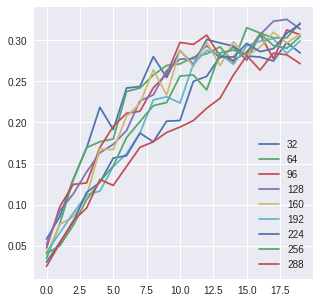

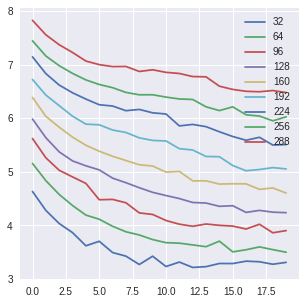

Considering that we will run the same model, with batch size 32 and 100 epochs.

In [0]:
trainModel(-1, 100, 32)

After run the 100 epochs, we observed that in the trainning set our model is with a good accuracy 0.9471, but validation accuracy is 0.2767 which means overfitting. Moreover, loss starts increase after twenty epochs.

The graphics below show this behavior.



We will try change regularization into layers, trying to finish the overfittings.
We will run another search for the regularization in layers of model, using the batch-size 32 adopted earlier.
For each regularization, value we also plot a graph to make easier understand the results.

The search was in values **0.001 , 0.005, 0.0075, 0.025, 0.05, 0.075, 0.1, 0.5, 1**

And the best results were observed to **0.0075**

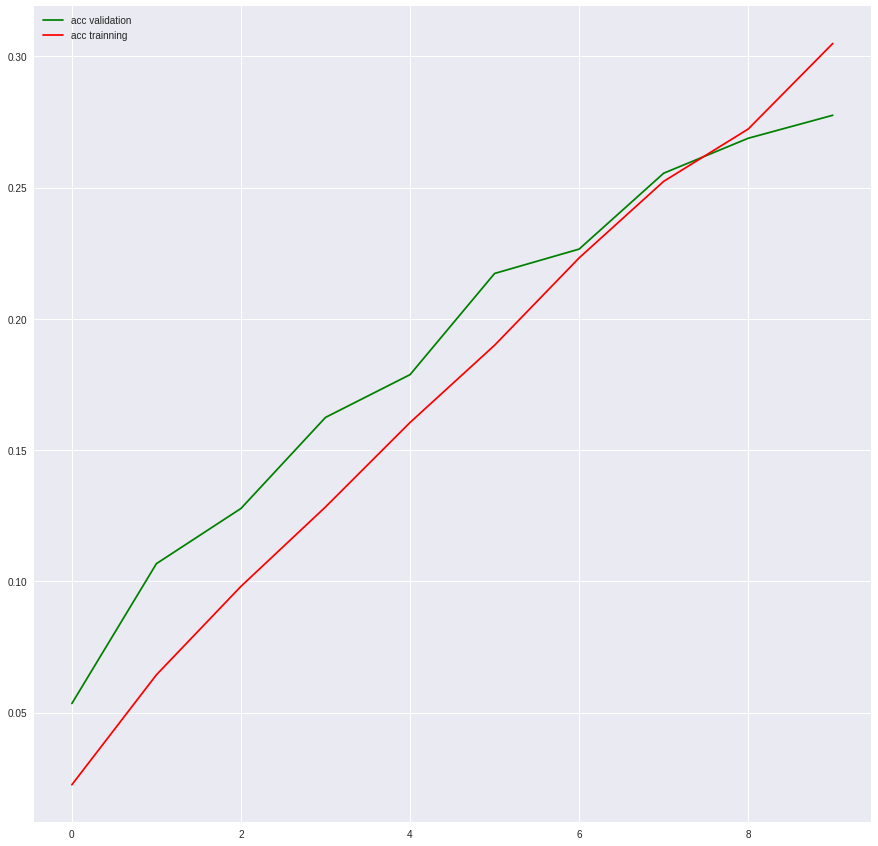

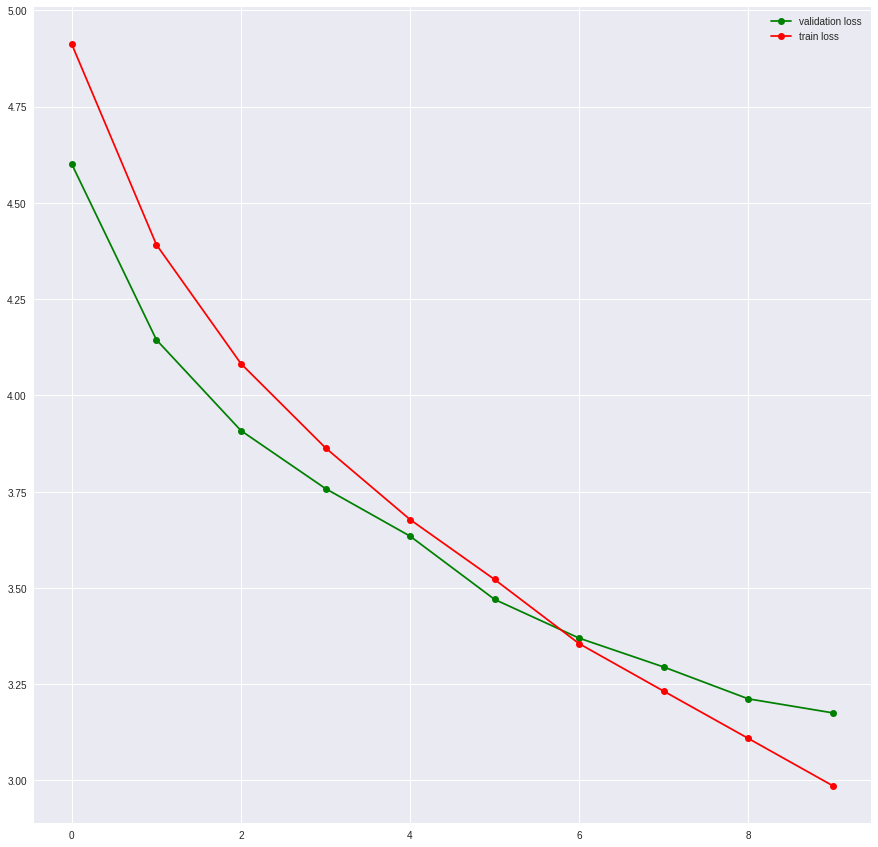

Looking best model - regularization  0.005
# trainModel - reg:  0.005
# trainModel - epochs:  10
# trainModel - batch_size:  32
Epoch 1/10
228/228 [==============================] - 100s 438ms/step - loss: 4.7259 - acc: 0.0330 - val_loss: 4.3942 - val_acc: 0.0688
Epoch 2/10
228/228 [==============================] - 96s 421ms/step - loss: 4.2452 - acc: 0.0767 - val_loss: 4.0860 - val_acc: 0.0904
Epoch 3/10
228/228 [==============================] - 96s 421ms/step - loss: 3.9269 - acc: 0.1080 - val_loss: 3.7644 - val_acc: 0.1468
Epoch 4/10
228/228 [==============================] - 95s 417ms/step - loss: 3.6986 - acc: 0.1377 - val_loss: 3.7433 - val_acc: 0.1260
Epoch 5/10
228/228 [==============================] - 95s 417ms/step - loss: 3.4967 - acc: 0.1822 - val_loss: 3.5163 - val_acc: 0.1631
Epoch 6/10
228/228 [==============================] - 96s 423ms/step - loss: 3.3307 - acc: 0.2130 - val_loss: 3.2960 - val_acc: 0.2231
Epoch 7/10
228/228 [==============================] - 95s 419

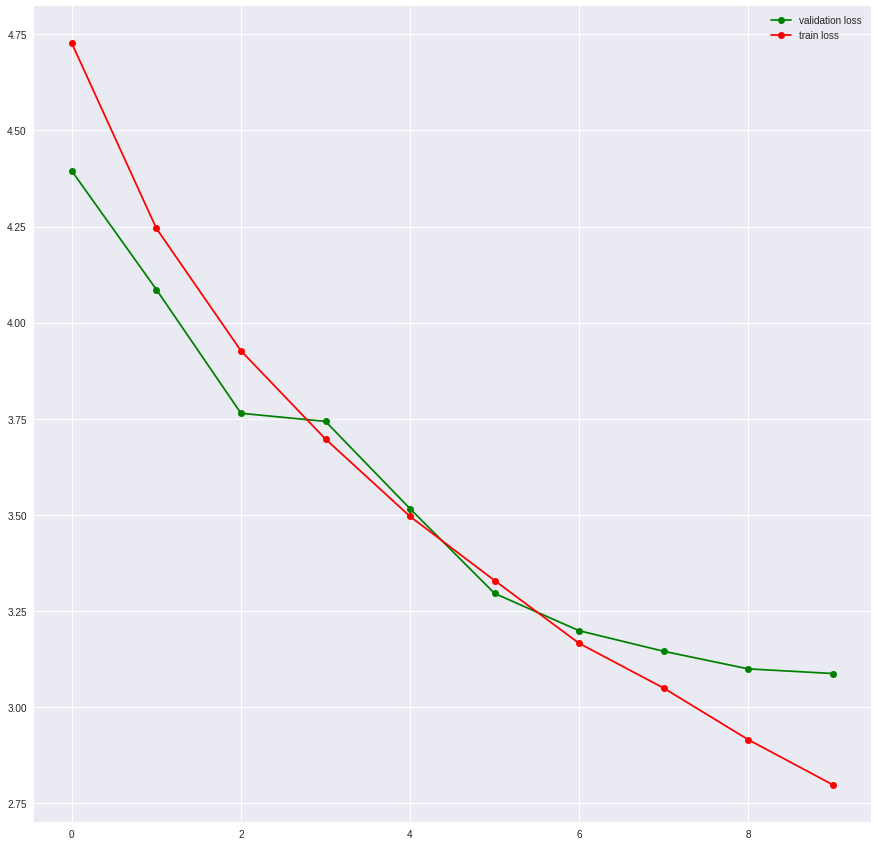

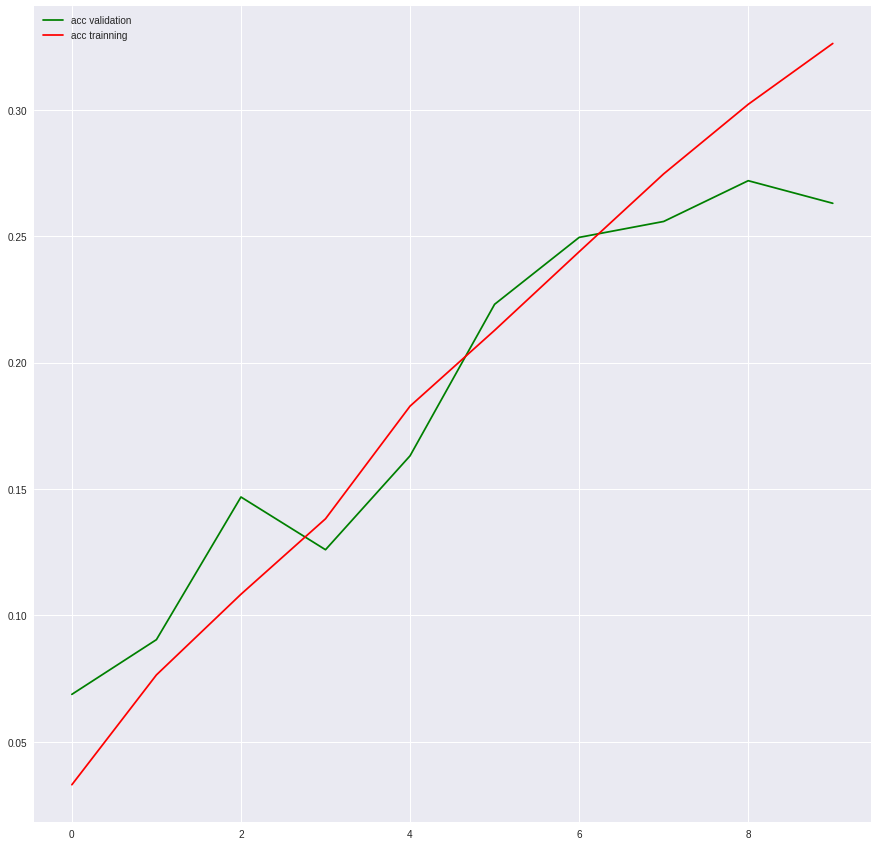

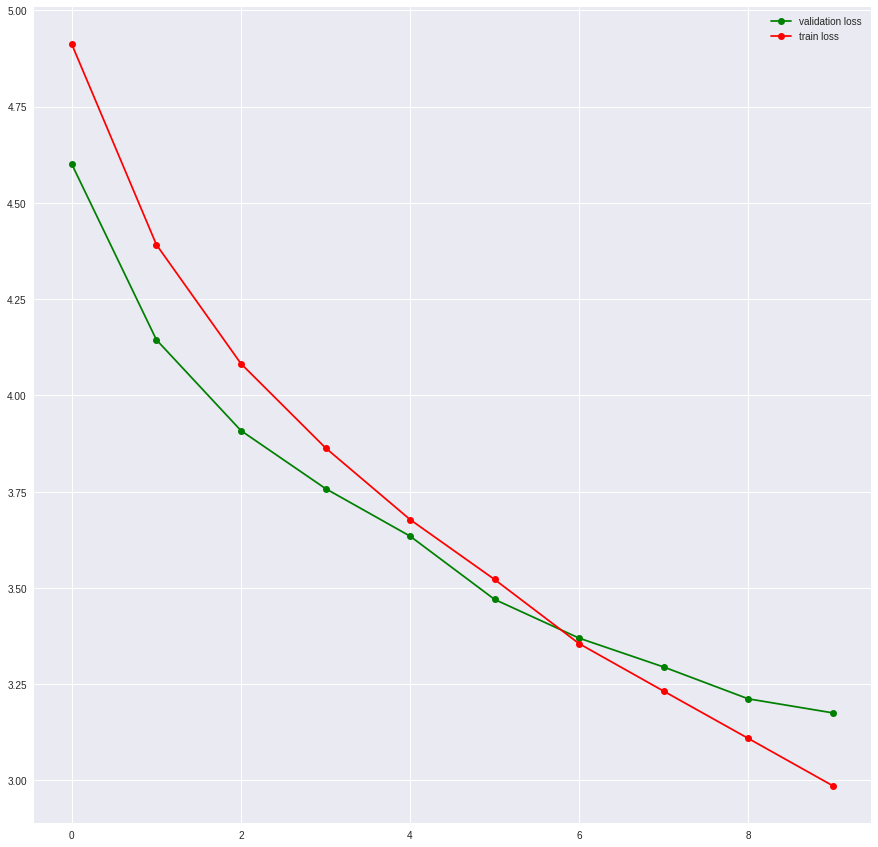

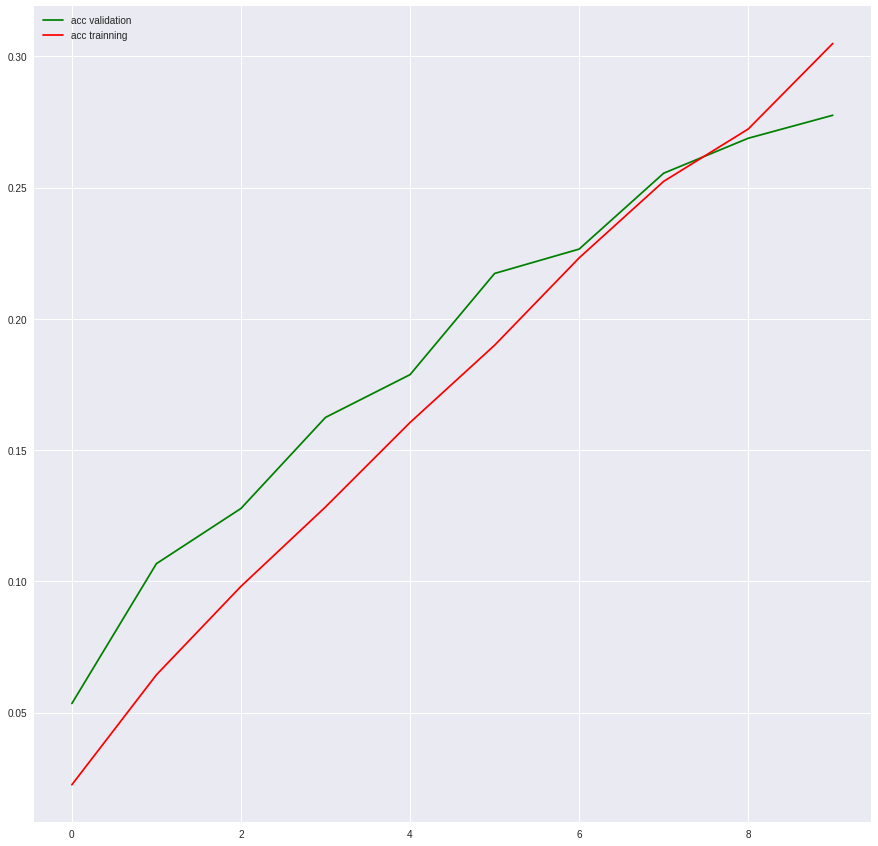

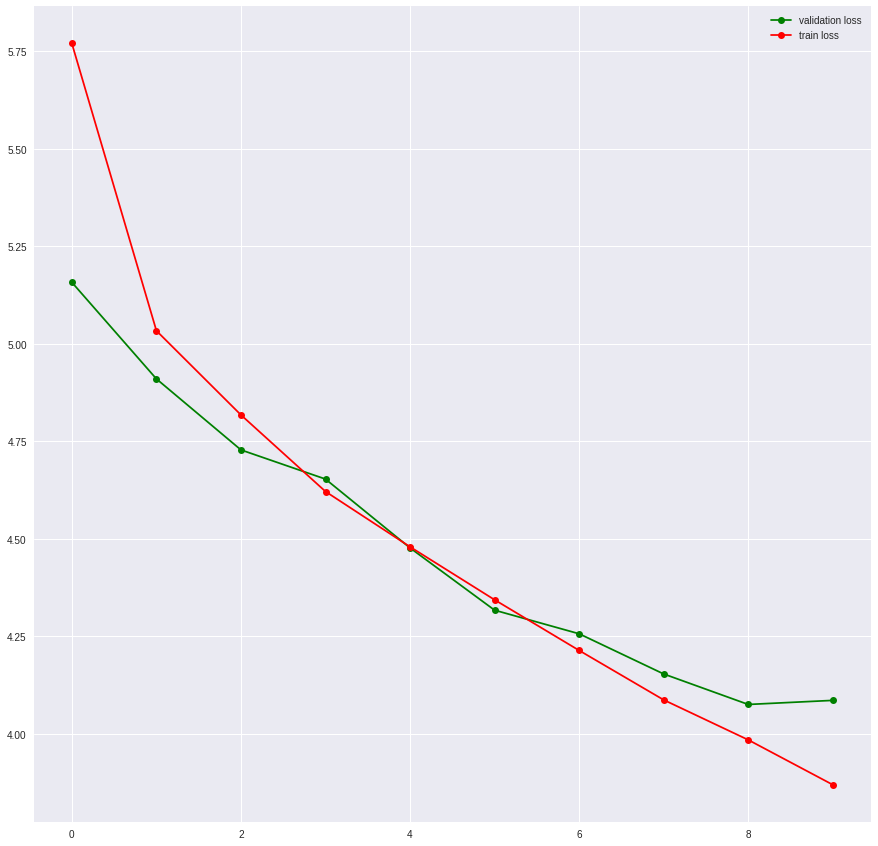

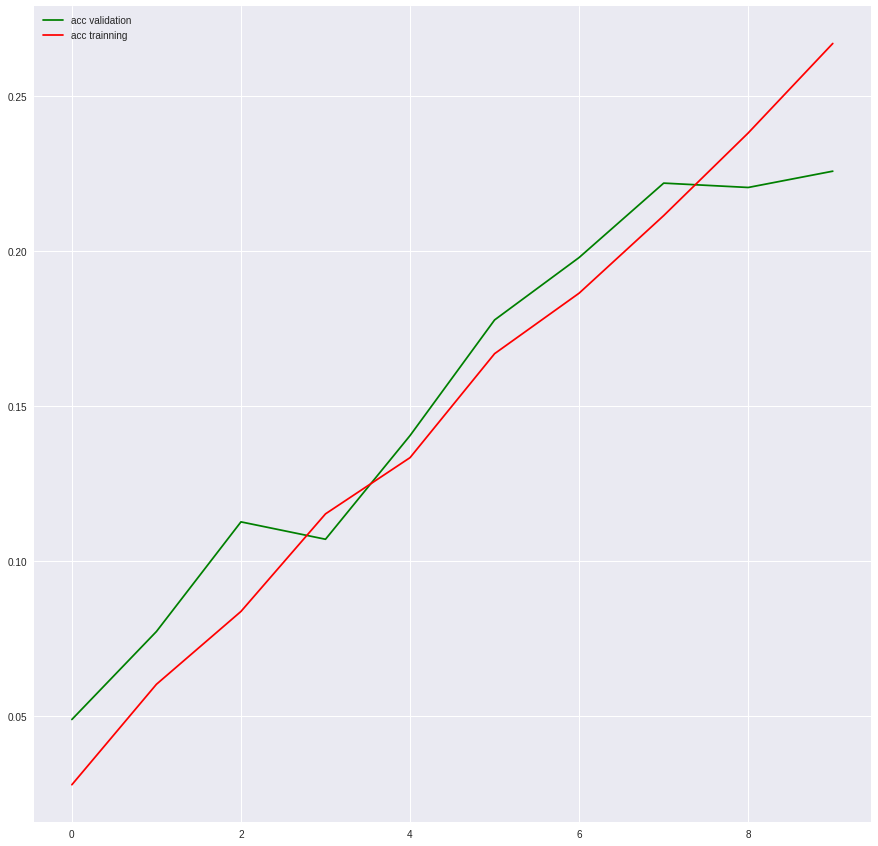

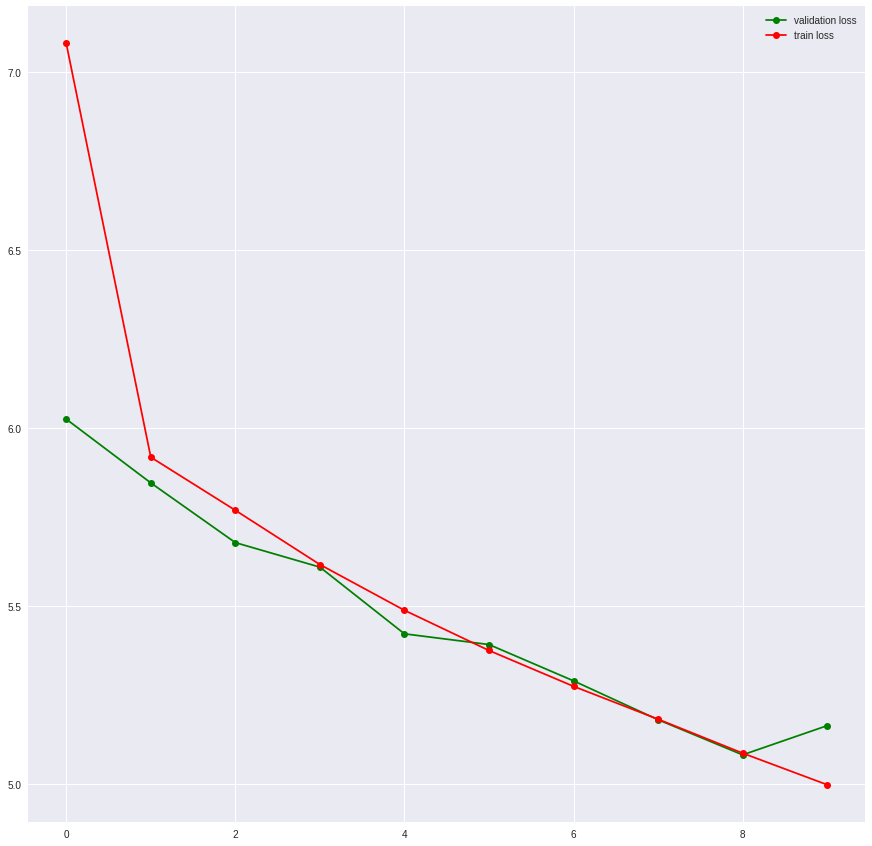

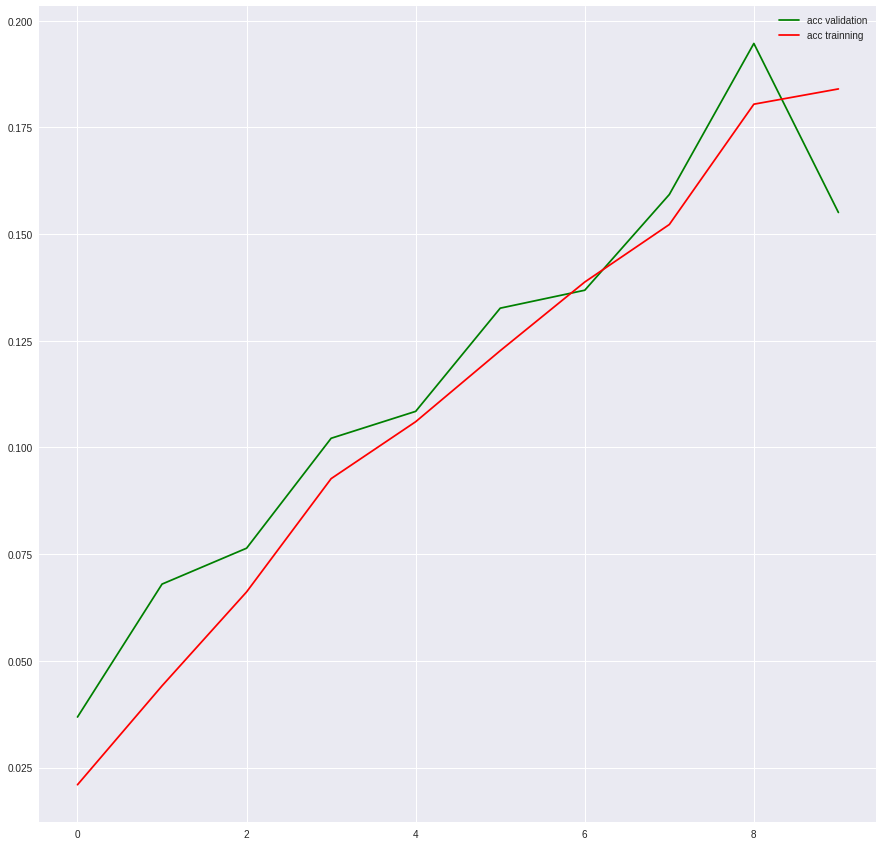

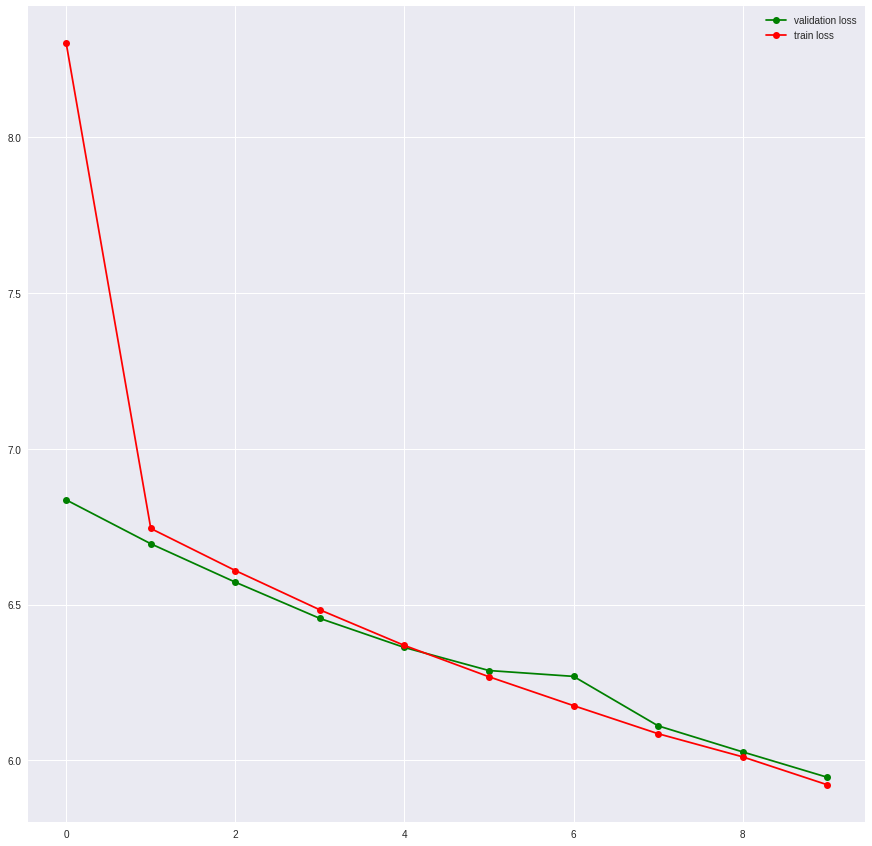

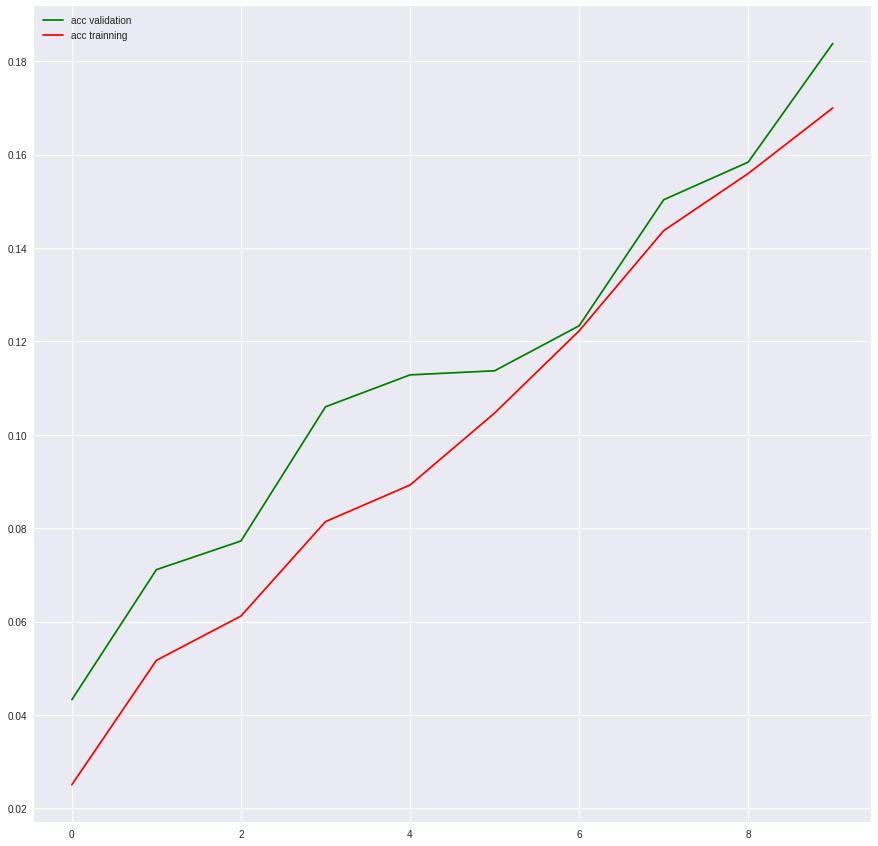

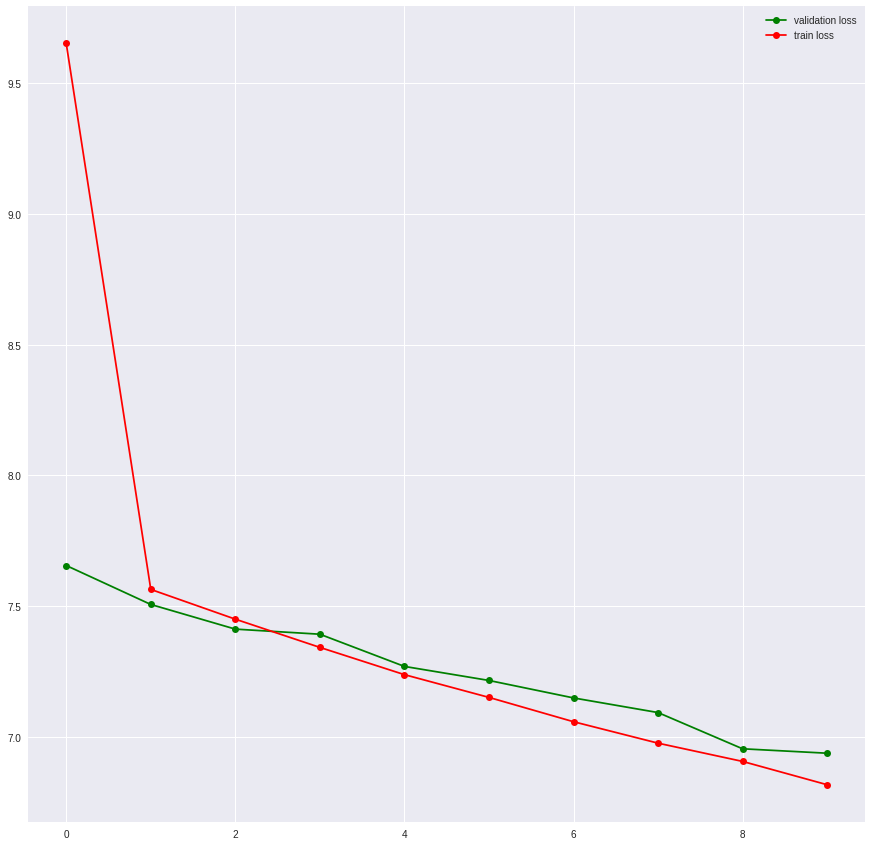

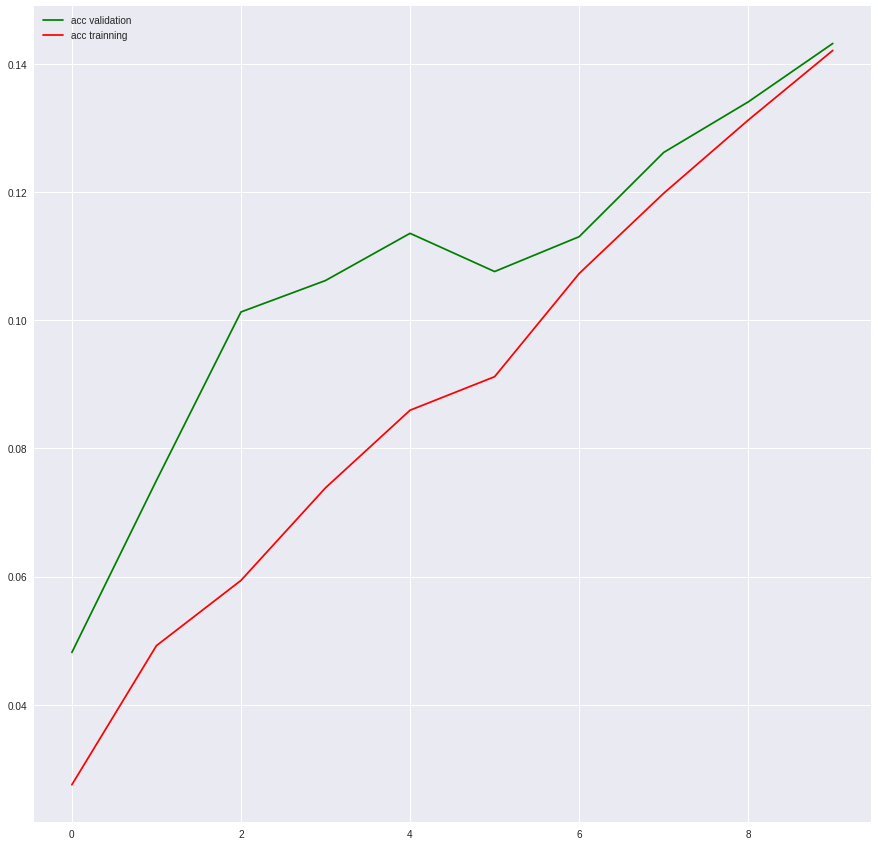

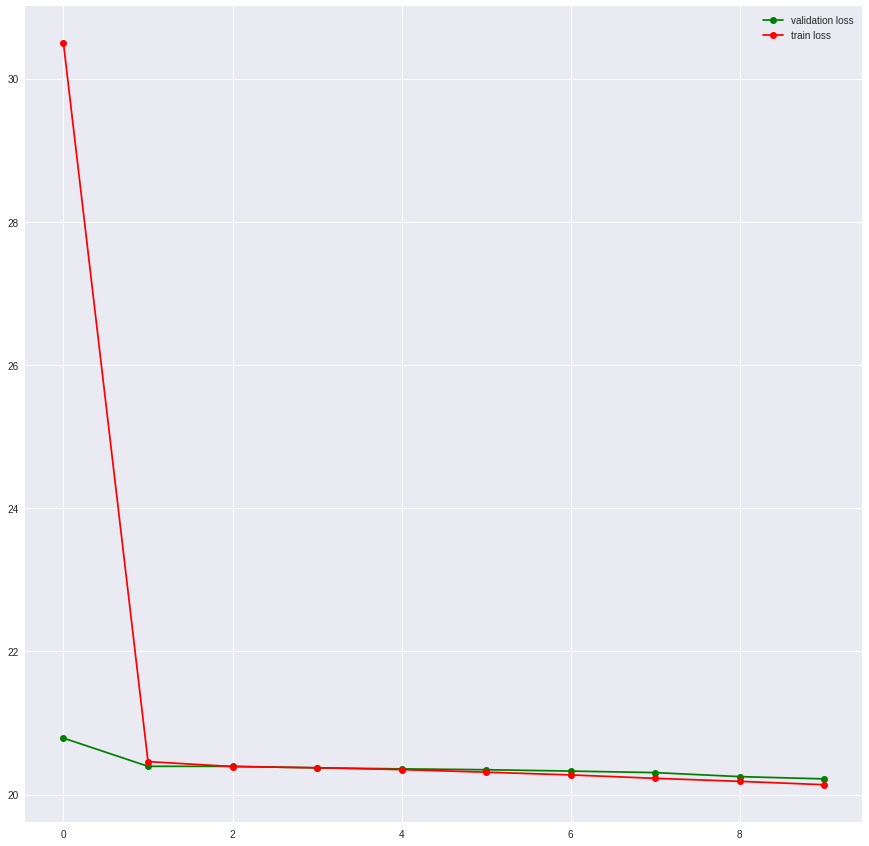

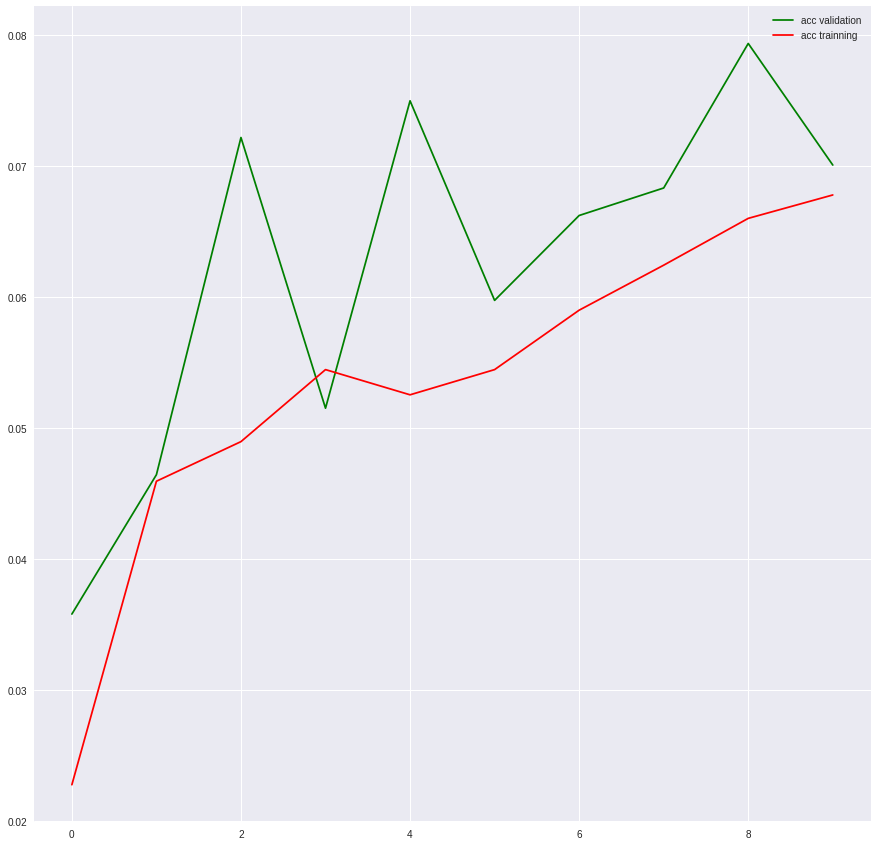

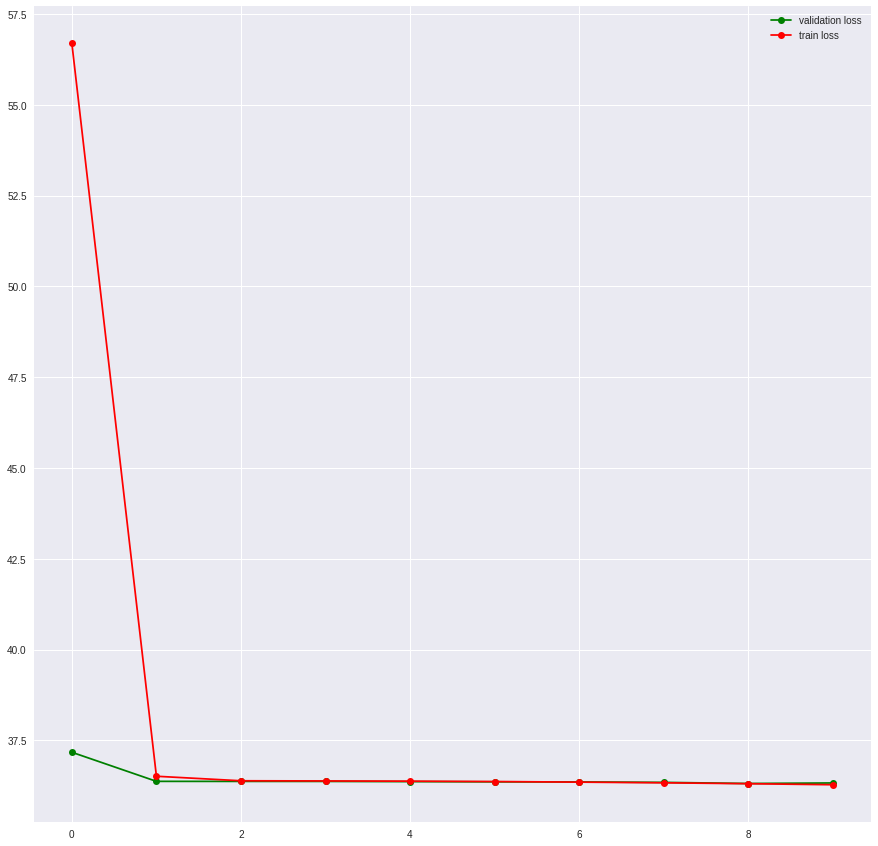

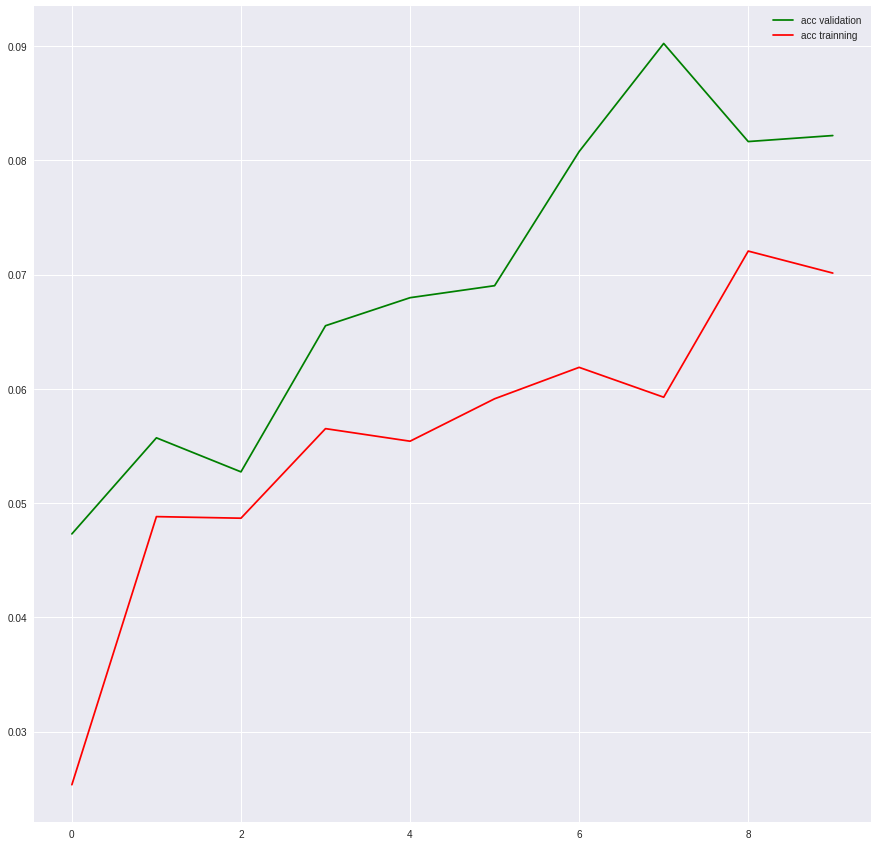

In [23]:
# 0.01 is default one, that is why I haven't added here
regs = [0.001 , 0.005, 0.0075, 0.025, 0.05, 0.075, 0.1, 0.5, 1]

for i in range(1,len(regs)):
    r = regs[i]
    print("Looking best model - regularization ", r)
    trainModel(r, 10, 32)
    

Once we decide use:
**batch-size: ** 32
**regularization: ** 0.0075

We trainned the model to 30 epochs and observed that we still have overfitting after **8** epochs.
According execution below.

# trainModel - reg:  0.0075
# trainModel - epochs:  30
# trainModel - batch_size:  32
Epoch 1/30
228/228 [==============================] - 110s 482ms/step - loss: 4.8738 - acc: 0.0334 - val_loss: 4.5213 - val_acc: 0.0639
Epoch 2/30
228/228 [==============================] - 100s 437ms/step - loss: 4.3392 - acc: 0.0755 - val_loss: 4.2044 - val_acc: 0.0894
Epoch 3/30
228/228 [==============================] - 99s 434ms/step - loss: 4.0130 - acc: 0.1146 - val_loss: 3.8438 - val_acc: 0.1430
Epoch 4/30
228/228 [==============================] - 104s 458ms/step - loss: 3.7807 - acc: 0.1466 - val_loss: 3.6567 - val_acc: 0.1885
Epoch 5/30
228/228 [==============================] - 103s 452ms/step - loss: 3.5773 - acc: 0.1855 - val_loss: 3.5483 - val_acc: 0.2201
Epoch 6/30
228/228 [==============================] - 100s 440ms/step - loss: 3.4199 - acc: 0.2129 - val_loss: 3.4657 - val_acc: 0.2273
Epoch 7/30
228/228 [==============================] - 98s 428ms/step - loss: 3.2823 - acc: 0.2429 -

(<keras.callbacks.History at 0x7fd5429638d0>,
 <keras.engine.training.Model at 0x7fd542963d68>)

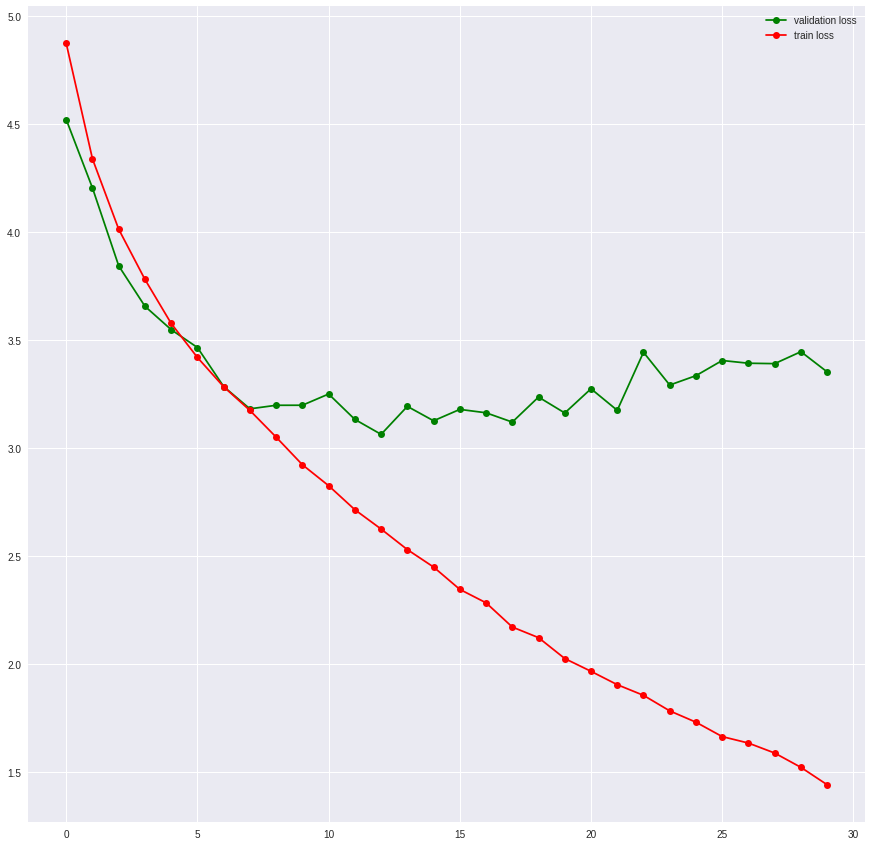

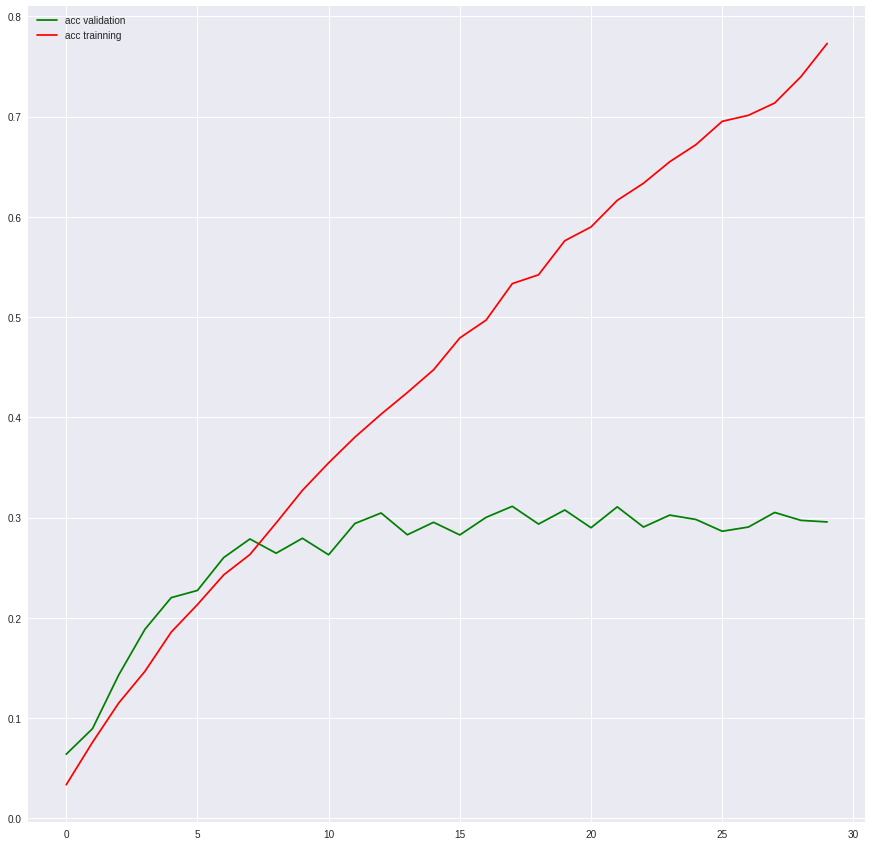

In [17]:
trainModel(0.0075, 30, 32)

# Teste [0.25 pts]
O teste será feito da mesma forma, utilizando `loadDatasetInBatches` para o conjunto de teste. 

Considering the overfitting after 8 epochs, we will train our model with 8 epochs and apply this model over test set.

# trainModel - reg:  0.0075
# trainModel - epochs:  8
# trainModel - batch_size:  32
Epoch 1/8
228/228 [==============================] - 99s 432ms/step - loss: 4.8846 - acc: 0.0312 - val_loss: 4.5526 - val_acc: 0.0489
Epoch 2/8
228/228 [==============================] - 93s 408ms/step - loss: 4.3746 - acc: 0.0683 - val_loss: 4.1618 - val_acc: 0.0876
Epoch 3/8
228/228 [==============================] - 94s 413ms/step - loss: 4.0445 - acc: 0.1058 - val_loss: 3.8953 - val_acc: 0.1489
Epoch 4/8
228/228 [==============================] - 94s 412ms/step - loss: 3.7973 - acc: 0.1495 - val_loss: 3.7353 - val_acc: 0.1705
Epoch 5/8
228/228 [==============================] - 94s 412ms/step - loss: 3.6066 - acc: 0.1769 - val_loss: 3.4717 - val_acc: 0.2253
Epoch 6/8
228/228 [==============================] - 95s 417ms/step - loss: 3.4628 - acc: 0.2088 - val_loss: 3.4302 - val_acc: 0.2178
Epoch 7/8
228/228 [==============================] - 94s 412ms/step - loss: 3.3135 - acc: 0.2440 - val_loss: 3.

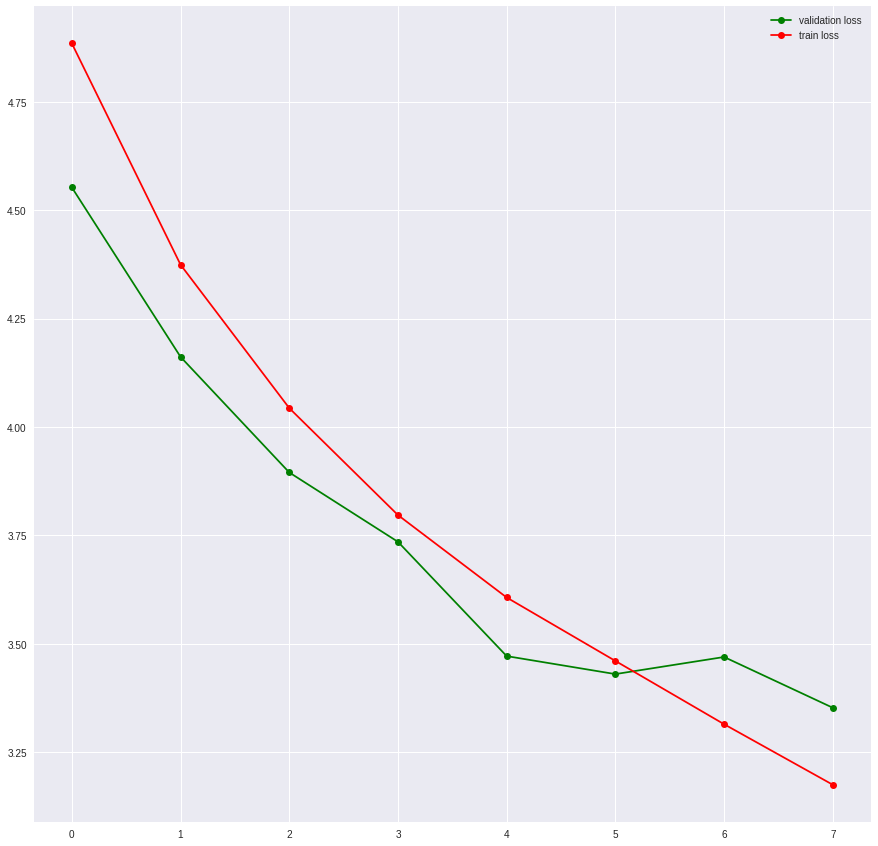

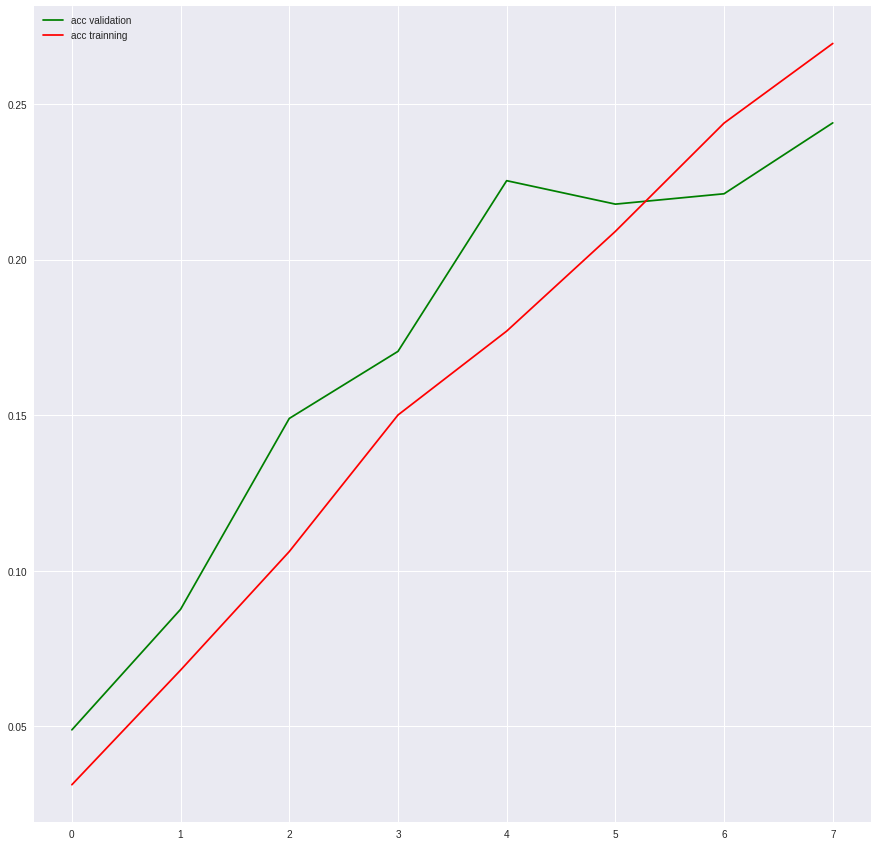

In [12]:
history, model = trainModel(0.0075, 8, 32)

#Criação do generator p/ o conjunto de teste
testGenerator = loadDatasetInBatches(split='test', batch_size=32)

#Teste
metrics = model.evaluate_generator(testGenerator, 
                                   steps=int(testSetSize/32), 
                                   verbose=1)

print("Test Loss ---> ", metrics[0])
print("Test Accuracy ---> ", metrics[1])    #Test is balanced, so Acc is normalized

# Conclusões  [0.25 pts]

Firstly, we have a lot of troubles to have a model with accuracy higher than 1. As we did in class 5 (transfer learning), we tried keep the network with original weights and add our layers into the end.

Than we start to unfreeze layers of squeezet to train its weights too, it enhanced the accuracy and we started change our layers to try increase results. 

We also observed that a lot of new layers were not enhancing results than we decide use the current layers and try adjust parameters: batch-size, epochs and regularization.

The batch-size 32 gave good results during the trainning (> 0.90), but bad results in validation (0.20 - 0.30) featuring a clear overfitting, that is why we decide invest in search for regularization. Although regularization didn't enhanced results as we needed.

** Our conclusions **
- Batch-size, epochs and regularization were not enough to enhance results.

Although they are powerfull tools to use in network, it was not enough.

- Our network must be changed

Accuracies (train: 0.2700, validation: 0.2439, test: 0.3119452662721893) are low and our classification will have a lot of mistakes. 

Loss are too high (2 - 3). It should be lower.

** Future Enhancements **

- Change network adding layers, changing parameters, performing optimizations, etc in order to get better results.

- 


